In [18]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.data_generation import generate_data
from hydra import compose, initialize
from omegaconf import OmegaConf

# load config using hydra
with initialize(version_base=None, config_path="config", job_name="test_app"):
    cfg = compose(config_name="config")

torch.set_num_threads(1)

In [19]:
OmegaConf.set_struct(cfg, False)

cfg.data.N = 1000
cfg.graph.graph_type = 'RANDOM'
cfg.graph.non_zero_prob = 0.001

In [20]:
device = torch.device('cpu')

# generate data and move to device
X, y, graph_filters_flat, weight_matrix, filter_coefficients = [d.to(device) for d in generate_data(cfg)]

In [21]:
y_in = y[:, :, 0].cpu().numpy()

hyperparams = {"P": 3,
                "gamma": 1.75,
                "lambda": 0.99,
                "nu": 0.005,
                "w_stepsize": 0.001,
                "h_stepsize": 0.001,
                "psi_stepsize": 1e-5,
                "use_eig_stepsize": False,
                "epsilon": 1e-3,
                "ma_alpha": 0.005,
                "use_path_1": True,
                "instant_h": True,
                "patience": 10000,
                "burn_in_debiasing": 250,
                "min_delta_percent": 0.01,
                "use_armijo": False,
                "use_armijo_w": False,
                "use_armijo_h": False,
                "warm_up_steps": 0,
                "alternate": False,
                "alternate_mod": 2,
                "monitor_debiasing": "pred_error_recursive_moving_average_h",
                "mus": [0.1, 0.1, 0.1],
                "record_complexity": True,
                "use_gt_sparsity": True
                }

eval_length = 100

from src.models.adaptive.AdaCGP_sparse import AdaCGP
model = AdaCGP(cfg.data.N, hyperparams, device)
model_inputs = {
    'X': X.cpu().numpy()[:eval_length],
    'y': y.cpu().numpy()[:eval_length],
    'weight_matrix': weight_matrix.cpu().numpy(),
    'filter_coefficients': filter_coefficients.cpu().numpy(),
    'graph_filter_matrix': graph_filters_flat.cpu().numpy(),
}
results = model.run(**model_inputs)

  0%|          | 0/100 [00:00<?, ?it/s, MA y error=1, Step=1e-5, Converged=0]/tmp/ipykernel_2770557/2498086225.py:41: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  results = model.run(**model_inputs)
  4%|▍         | 4/100 [00:04<01:47,  1.12s/it, MA y error=1, Step=1e-5, Converged=0]


KeyboardInterrupt: 

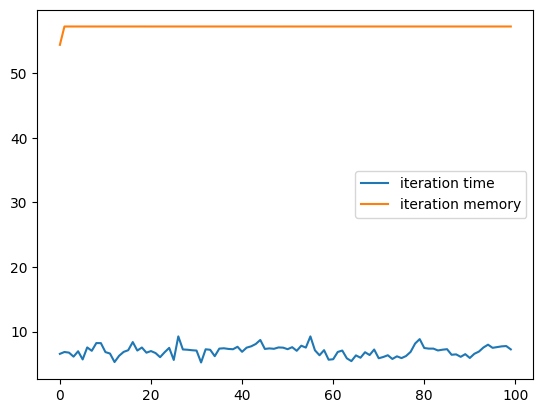

In [5]:
plt.plot(results['iteration_time'], label='iteration time')
plt.plot(results['iteration_memory'], label='iteration memory')
plt.legend()

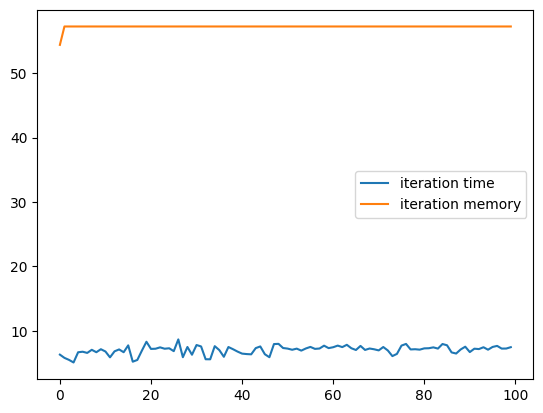

In [8]:
plt.plot(results['iteration_time'], label='iteration time')
plt.plot(results['iteration_memory'], label='iteration memory')
plt.legend()

In [6]:
print(X.shape, y.shape)

torch.Size([10000, 3, 50]) torch.Size([10000, 50, 1])


Starting complexity analysis...

Testing with N = 10
  Trial 1/1


100%|██████████| 100/100 [00:00<00:00, 245.46it/s, MA y error=0.991, Step=1e-5, Converged=0]


  Results: Time = 0.0041s, Memory = 0.14 MB

Testing with N = 33
  Trial 1/1


100%|██████████| 100/100 [00:00<00:00, 229.55it/s, MA y error=0.99, Step=1e-5, Converged=0]


  Results: Time = 0.0044s, Memory = 0.58 MB

Testing with N = 100
  Trial 1/1


100%|██████████| 100/100 [00:00<00:00, 116.50it/s, MA y error=0.989, Step=1e-5, Converged=0]


  Results: Time = 0.0086s, Memory = 3.71 MB

Testing with N = 330
  Trial 1/1


100%|██████████| 100/100 [00:06<00:00, 15.90it/s, MA y error=0.984, Step=1e-5, Converged=0]


  Results: Time = 0.0629s, Memory = 39.57 MB

Testing with N = 1000
  Trial 1/1


100%|██████████| 100/100 [01:14<00:00,  1.34it/s, MA y error=0.971, Step=1e-5, Converged=0]


  Results: Time = 0.7440s, Memory = 362.59 MB

Analyzing results...

Empirical Time Complexity: O(n^1.13)
Empirical Space Complexity: O(n^1.73)

Detailed Results:
N = 10: Time = 0.0041s, Memory = 0.14 MB
N = 33: Time = 0.0044s, Memory = 0.58 MB
N = 100: Time = 0.0086s, Memory = 3.71 MB
N = 330: Time = 0.0629s, Memory = 39.57 MB
N = 1000: Time = 0.7440s, Memory = 362.59 MB


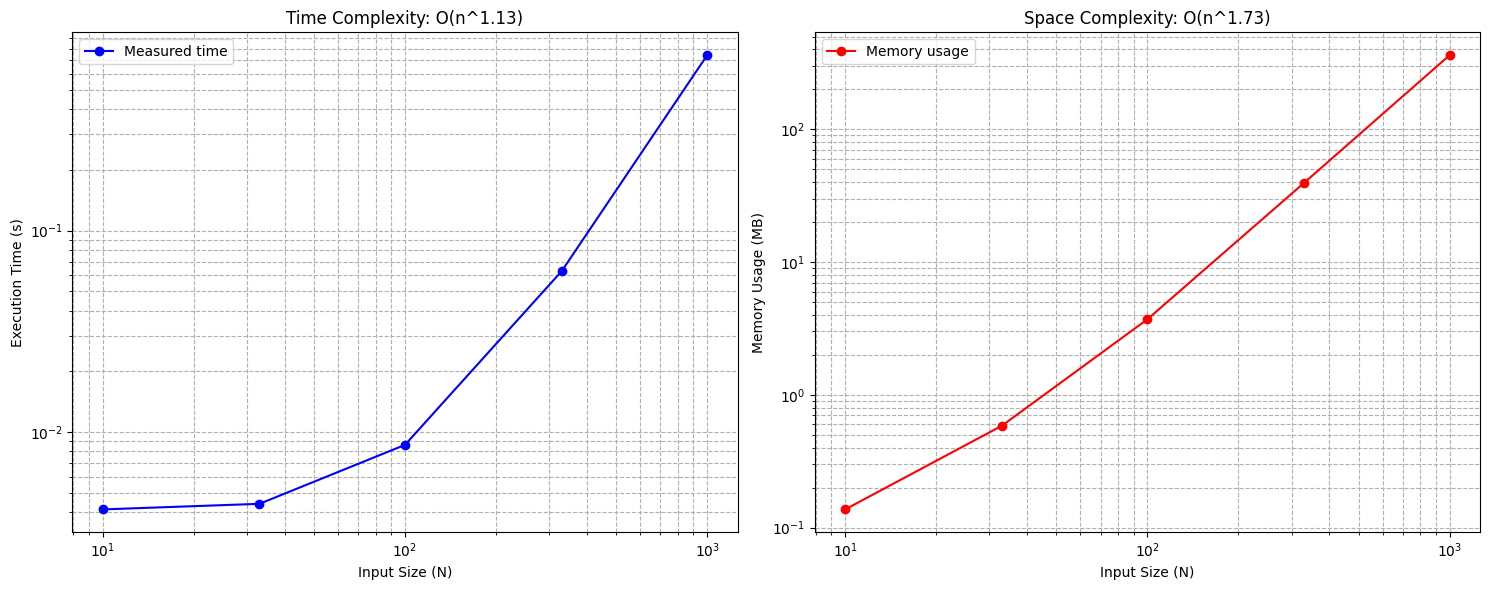

In [10]:
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.data_generation import generate_data
from hydra import compose, initialize
from omegaconf import OmegaConf
import psutil
import gc
import tracemalloc
from src.models.adaptive.AdaCGP_numpy import AdaCGP

def measure_performance(N_values, cfg, hyperparams, device='cpu', num_trials=3, series_length=100):
    """
    Measure time and space complexity of model.run for different input sizes.
    
    Args:
        N_values: List of N values to test
        cfg: Configuration object
        hyperparams: Model hyperparameters
        device: Computing device
        num_trials: Number of trials to run for each N (to reduce variance)
        
    Returns:
        N_values, time_results, memory_results
    """
    time_results = []
    memory_results = []
    
    for N in N_values:
        print(f"\nTesting with N = {N}")
        
        # Update configuration
        cfg.data.N = N
        
        trial_times = []
        trial_memory = []
        
        for trial in range(num_trials):
            print(f"  Trial {trial+1}/{num_trials}")
            
            # Generate data for this size
            X, y, graph_filters_flat, weight_matrix, filter_coefficients = [d.to(device) for d in generate_data(cfg)]
            
            # Convert to numpy
            X_np = X.cpu().numpy()[:series_length]
            y_np = y.cpu().numpy()[:series_length]
            weight_matrix_np = weight_matrix.cpu().numpy()
            filter_coefficients_np = filter_coefficients.cpu().numpy()
            graph_filters_flat_np = graph_filters_flat.cpu().numpy()

            # Initialize model
            model = AdaCGP(N, hyperparams, device)
            
            # Prepare inputs
            model_inputs = {
                'X': X_np,
                'y': y_np,
                'weight_matrix': weight_matrix_np,
                'filter_coefficients': filter_coefficients_np,
                'graph_filters_flat': graph_filters_flat_np,
            }
            
            # Measure memory usage and execution time
            gc.collect()  # Force garbage collection
            
            # Start memory tracking
            tracemalloc.start()
            
            # Measure time
            start_time = time.time()
            results = model.run(**model_inputs)
            end_time = time.time()
            
            # Get peak memory usage
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            
            execution_time = end_time - start_time
            trial_times.append(execution_time / series_length)  # Divide by series length to get per-step time
            trial_memory.append(peak / (1024 * 1024))  # Convert to MB
            
            # Clean up
            del model, X, y, weight_matrix, filter_coefficients, graph_filters_flat
            del X_np, y_np, weight_matrix_np, filter_coefficients_np, graph_filters_flat_np
            gc.collect()
        
        # Use median values to reduce impact of outliers
        time_results.append(np.median(trial_times))
        memory_results.append(np.median(trial_memory))
        
        print(f"  Results: Time = {time_results[-1]:.4f}s, Memory = {memory_results[-1]:.2f} MB")
    
    return N_values, time_results, memory_results

def analyze_complexity(N_values, time_results, memory_results):
    """
    Analyze and visualize the empirical complexity.
    
    Args:
        N_values: List of input sizes
        time_results: List of execution times
        memory_results: List of memory usage
        
    Returns:
        time_complexity, memory_complexity estimates
    """
    # Convert to numpy arrays
    N_array = np.array(N_values)
    time_array = np.array(time_results)
    memory_array = np.array(memory_results)
    
    # Fit polynomial curves to determine complexity
    if len(N_values) >= 3:  # Need at least 3 points for a meaningful fit
        time_coeffs = np.polyfit(np.log(N_array), np.log(time_array), 1)
        memory_coeffs = np.polyfit(np.log(N_array), np.log(memory_array), 1)
        
        time_complexity = f"O(n^{time_coeffs[0]:.2f})"
        memory_complexity = f"O(n^{memory_coeffs[0]:.2f})"
    else:
        time_complexity = "Insufficient data points"
        memory_complexity = "Insufficient data points"
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Time complexity plot
    ax1.loglog(N_array, time_array, 'bo-', label='Measured time')
    ax1.set_xlabel('Input Size (N)')
    ax1.set_ylabel('Execution Time (s)')
    ax1.set_title(f'Time Complexity: {time_complexity}')
    ax1.grid(True, which="both", ls="--")
    ax1.legend()
    
    # Space complexity plot
    ax2.loglog(N_array, memory_array, 'ro-', label='Memory usage')
    ax2.set_xlabel('Input Size (N)')
    ax2.set_ylabel('Memory Usage (MB)')
    ax2.set_title(f'Space Complexity: {memory_complexity}')
    ax2.grid(True, which="both", ls="--")
    ax2.legend()
    
    plt.tight_layout()
    
    return time_complexity, memory_complexity

if __name__ == "__main__":
    # Load config using hydra
    with initialize(version_base=None, config_path="config", job_name="test_app"):
        cfg = compose(config_name="config")
    
    torch.set_num_threads(1)
    device = torch.device('cpu')
    
    # Define hyperparameters
    hyperparams = {"P": 3,
                   "gamma": 1.75,
                   "lambda": 0.99,
                   "nu": 0.005,
                   "w_stepsize": 0.001,
                   "h_stepsize": 0.001,
                   "psi_stepsize": 1e-5,
                   "use_eig_stepsize": False,
                   "epsilon": 1e-3,
                   "ma_alpha": 0.005,
                   "use_path_1": True,
                   "instant_h": True,
                   "patience": 10000,
                   "burn_in_debiasing": 250,
                   "min_delta_percent": 0.01,
                   "use_armijo": False,
                   "use_armijo_w": False,
                   "use_armijo_h": False,
                   "warm_up_steps": 0,
                   "alternate": False,
                   "alternate_mod": 2,
                   "monitor_debiasing": "pred_error_recursive_moving_average_h",
                   "mus": [0.1, 0.1, 0.1],
                   "streamline": True,
                  }
    
    # Set graph type
    cfg.graph.graph_type = 'RANDOM'
    
    # Define range of N values to test
    # Start with smaller values for initial testing
    N_values = [10, 33, 100, 330, 1000]
    
    print("Starting complexity analysis...")
    N_values, time_results, memory_results = measure_performance(N_values, cfg, hyperparams, device, num_trials=1)
    
    print("\nAnalyzing results...")
    time_complexity, memory_complexity = analyze_complexity(N_values, time_results, memory_results)
    
    print(f"\nEmpirical Time Complexity: {time_complexity}")
    print(f"Empirical Space Complexity: {memory_complexity}")

    print("\nDetailed Results:")
    for i, N in enumerate(N_values):
        print(f"N = {N}: Time = {time_results[i]:.4f}s, Memory = {memory_results[i]:.2f} MB")

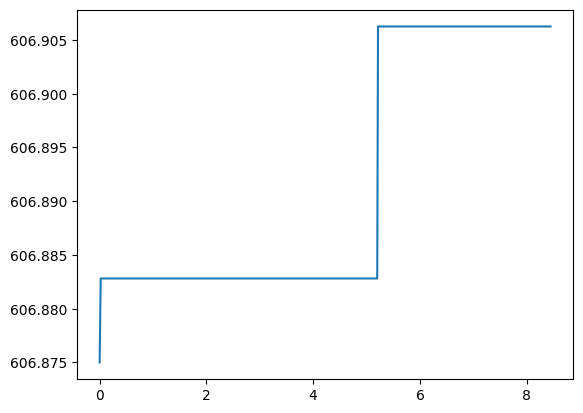

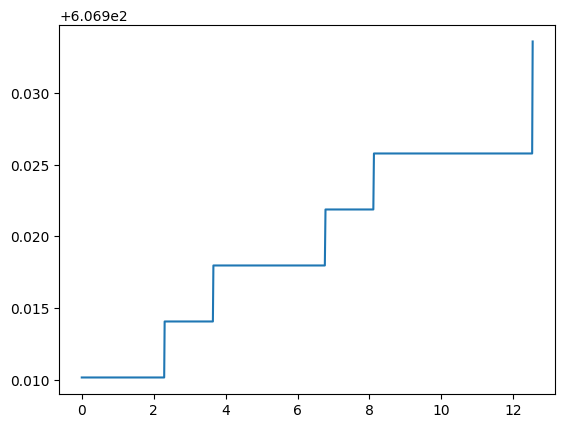

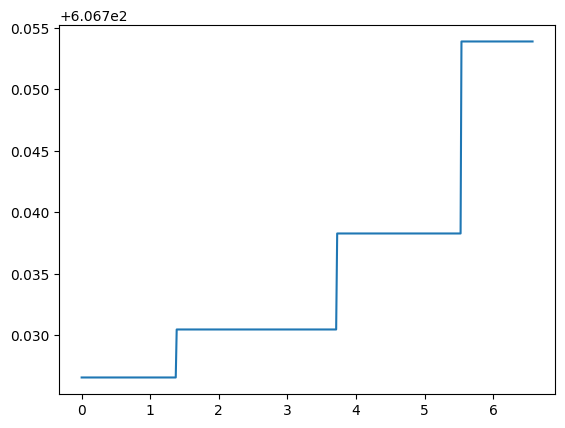

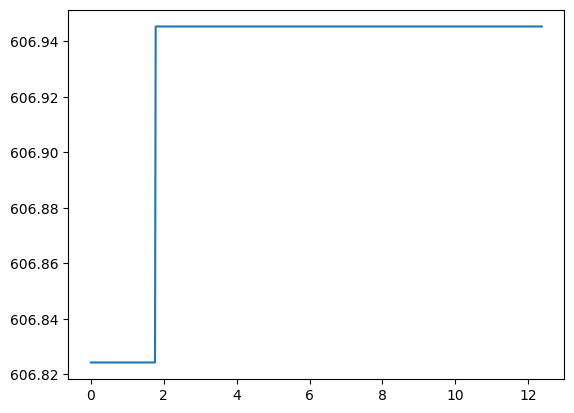

In [19]:
for k in memory_fluctuations.keys():

    t = memory_fluctuations[k]['timestamps']
    m = memory_fluctuations[k]['memory']

    plt.plot(t, m)
    plt.show()